## CoIP vs. Predicted
In this notebook, we'll generate a plot of the fold change from a CoIP experiment against the confidence and RMSD sums from AlphaFold predictions.

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy.stats import ttest_ind

## Read in the data
We need both the CoIP data and the RMSD analysis output.

In [7]:
enriched = pd.read_excel('/mnt/research/Walker_Lab_Research/Serena_project_data/alpha_utility_data/data/anne/CmerolaeCoIP_WistarProteomics.xlsx', sheet_name='141 Enriched proteins')[['Accession', 'Fold Change CM_vs_CMC']]
enriched.head()

,Accession,Fold Change CM_vs_CMC
0,CMH170CT,3910.855425
1,CML232CT,522.354930
2,CMR341CT,195.389464
3,CMJ081CT,122.542684
4,CMD011CT,106.298454


In [8]:
confidences = pd.read_csv('/mnt/research/Walker_Lab_Research/Serena_project_data/alpha_utility_data/data/anne/alphafold_outputs/30Apr2025/30Apr2025_rmsd_analysis.csv')
confidences.head()

,name,meanconfidence,rmsdsum
0,gnlcmercma041c_rubisco,0.804319,228.873631
1,gnlcmercmb102c_rubisco,0.801470,201.291355
2,gnlcmercmb148c_rubisco,0.892476,123.245080
3,gnlcmercmc011c_rubisco,0.715391,406.589266
4,gnlcmercmc066c_rubisco,0.822781,153.923192


## Data wrangling
We need to match the ID's from the CoIP experiment to the names of our AlphaFold outputs. This should be as easy as removing the `gnlcmer` and `_rubisco` from the AlphaFold ID's and adding a `T` to the end.

In [5]:
confidences['Accession'] = confidences['name'].str.split('_').str[0].str[7:].str.upper() + 'T'
confidences.head()

,name,meanconfidence,rmsdsum,Accession
0,gnlcmercma041c_rubisco,0.804319,228.873631,CMA041CT
1,gnlcmercmb102c_rubisco,0.801470,201.291355,CMB102CT
2,gnlcmercmb148c_rubisco,0.892476,123.245080,CMB148CT
3,gnlcmercmc011c_rubisco,0.715391,406.589266,CMC011CT
4,gnlcmercmc066c_rubisco,0.822781,153.923192,CMC066CT


Let's make sure they correspond:

In [6]:
len(set(confidences.Accession.tolist())), len(set(enriched.Accession.tolist())), len(set(confidences.Accession.tolist()).intersection(set(enriched.Accession.tolist())))

(140, 141, 140)

Looks like our confidences is missing a protein -- this could have happened when we ran the AlphaFold predictions, so we should go back and check there. For now, we'll move on, and combine the two datasets with an inner join.

In [7]:
to_plot = confidences.drop(columns=['name']).merge(enriched, left_on='Accession', right_on='Accession', how='inner')
to_plot.head()

,meanconfidence,rmsdsum,Accession,Fold Change CM_vs_CMC
0,0.804319,228.873631,CMA041CT,3.801790
1,0.801470,201.291355,CMB102CT,3.675339
2,0.892476,123.245080,CMB148CT,14.986511
3,0.715391,406.589266,CMC011CT,3.564322
4,0.822781,153.923192,CMC066CT,3.224364


Now drop any negative confidence values:

In [8]:
to_plot = to_plot[to_plot['meanconfidence'] > 0]
print(f'There are {len(to_plot)} rows after cleaning.')

There are 137 rows after cleaning.


## Plot
We're going to make separate 2D plots as well as a 3D plot combining the RMSD and confidence comparisons.

### Confidence

Text(0, 0.5, 'CoIP Fold Change')

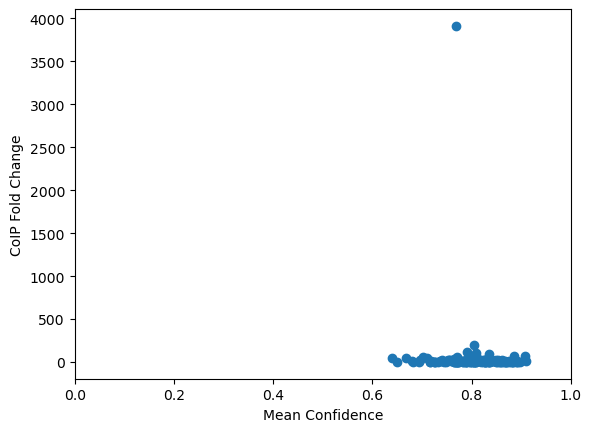

In [9]:
plt.scatter(to_plot.meanconfidence, to_plot['Fold Change CM_vs_CMC'])
plt.xlim(0, 1)
plt.xlabel('Mean Confidence')
plt.ylabel('CoIP Fold Change')

The range of fold changes makes this plot difficult to interpret; let's plot the y-axis on a log scale.

Text(0, 0.5, 'log2(CoIP Fold Change)')

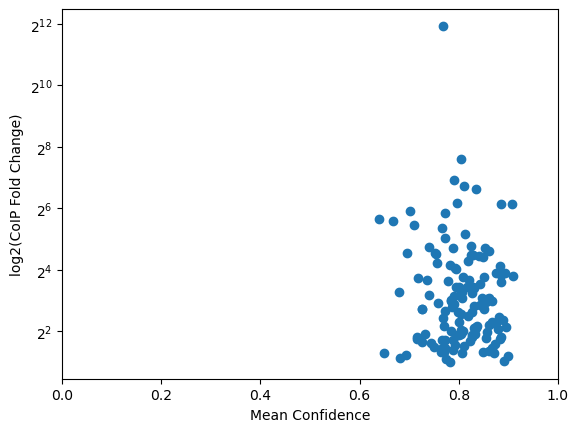

In [10]:
plt.semilogy(to_plot.meanconfidence, to_plot['Fold Change CM_vs_CMC'],'o', base=2)
plt.xlim(0, 1)
plt.xlabel('Mean Confidence')
plt.ylabel('log2(CoIP Fold Change)')

### RMSD

Text(0, 0.5, 'log2(CoIP Fold Change)')

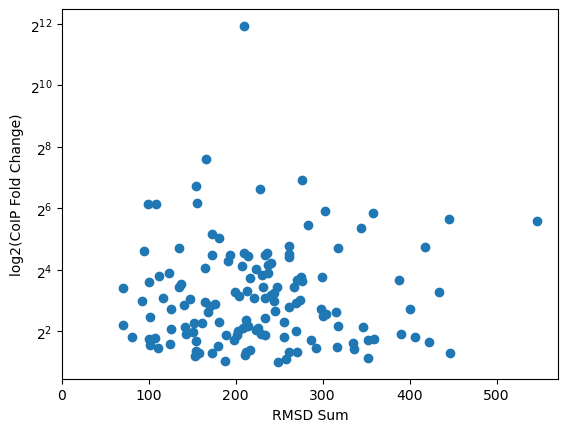

In [11]:
plt.semilogy(to_plot.rmsdsum, to_plot['Fold Change CM_vs_CMC'], 'o', base=2)
plt.xlim(xmin=0)
plt.xlabel('RMSD Sum')
plt.ylabel('log2(CoIP Fold Change)')

### 3D combined plot
Apparently, there's no [good solution for logging an axis in 3D](https://stackoverflow.com/a/17363073) with matplotlib. We'll do the easy thing and apply the log to the column in question before plotting.

In [12]:
to_plot['log10_fold_change'] = np.log2(to_plot['Fold Change CM_vs_CMC'])

Text(0.5, 0, 'log10(CoIP Fold Change)')

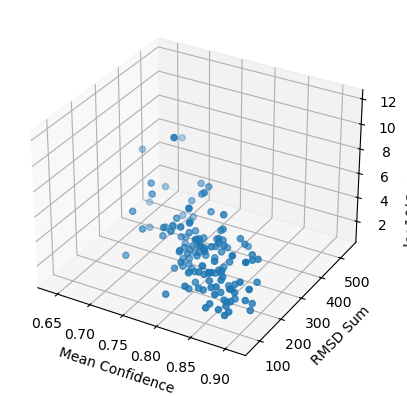

In [13]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(to_plot['meanconfidence'], to_plot['rmsdsum'], to_plot['log10_fold_change'], marker='o')
ax.set_xlabel('Mean Confidence')
ax.set_ylabel('RMSD Sum')
ax.set_zlabel('log10(CoIP Fold Change)')

## Comparing to a random subset
We also want to make these graphs for a random subset of 141 proteins, to make sure that the high confidences for the coIP targets isn't an artefact of the way AlphaFold makes predictions.

In [4]:
random = pd.read_csv('/mnt/research/Walker_Lab_Research/Serena_project_data/alpha_utility_data/data/anne/alphafold_outputs/16Jun2025_analysis_rmsd_analysis.csv')
random.head()

,name,meanconfidence,rmsdsum
0,gnlcmercma025c_rubisco_20250617_162400,0.816996,267.393368
1,gnlcmercma061c_rubisco_20250617_162400,0.754322,284.407250
2,gnlcmercma078c_rubisco_20250617_162400,0.921492,112.502628
3,gnlcmercma083c_rubisco_20250617_162357,0.787599,181.417870
4,gnlcmercma135c_rubisco_20250617_162357,0.801609,204.771320


Check for overlap with the actual subset (I didn't rule out proteins from the original in my sampling):

In [9]:
random_partners = set(random.name.str.split('_', expand=True)[0])
original_partners = set(confidences.name.str.split('_', expand=True)[0])
print(len(random_partners), len(original_partners), len(random_partners.intersection(original_partners)))

139 140 3


Only 3 overlap! We can't make the same plots that we did for the actual set, because we don't have coIP data for them; however, we can make a historgram of the confidences and RMSD and compare those to a histogram of the actual set to see if they're meaningfully different.

First, drop rows with confidence < 0, means that ALphaFold exploded on them:

In [11]:
confidences = confidences[confidences['meanconfidence'] > 0]
random = random[random['meanconfidence'] > 0]

In [13]:
random

,name,meanconfidence,rmsdsum
0,gnlcmercma025c_rubisco_20250617_162400,0.816996,267.393368
1,gnlcmercma061c_rubisco_20250617_162400,0.754322,284.407250
2,gnlcmercma078c_rubisco_20250617_162400,0.921492,112.502628
3,gnlcmercma083c_rubisco_20250617_162357,0.787599,181.417870
4,gnlcmercma135c_rubisco_20250617_162357,0.801609,204.771320
...,...,...,...
134,gnlcmercmt522c_rubisco_20250617_221502,0.832909,210.320735
135,gnlcmercmt537c_rubisco_20250617_221500,0.747385,54.318230
136,gnlcmercmt565c_rubisco_20250617_221500,0.784163,263.266426
137,gnlcmercmv019c_rubisco_20250617_221500,0.652489,345.062643


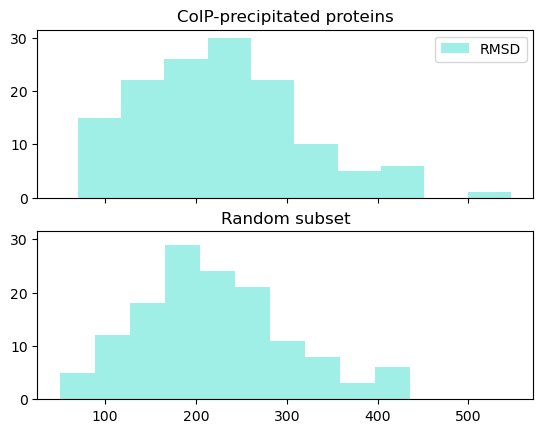

In [21]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)

axs[0].hist(confidences.rmsdsum, color='turquoise', alpha=0.5, label='RMSD')
axs[0].set_title('CoIP-precipitated proteins')

axs[1].hist(random.rmsdsum, color='turquoise', alpha=0.5, label='RMSD')
axs[1].set_title('Random subset')

axs[0].legend()

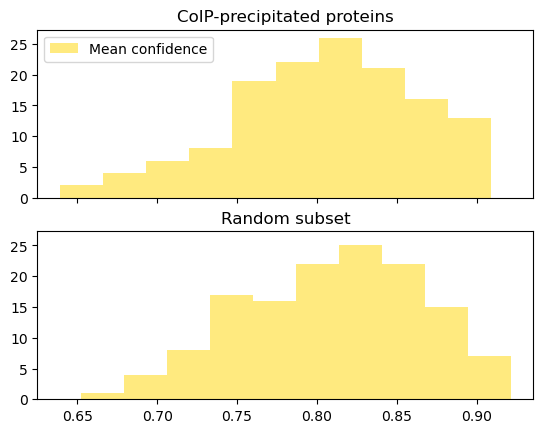

In [20]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)

axs[0].hist(confidences.meanconfidence, color='gold', alpha=0.5, label='Mean confidence')
axs[0].set_title('CoIP-precipitated proteins')

axs[1].hist(random.meanconfidence, color='gold', alpha=0.5, label='Mean confidence')
axs[1].set_title('Random subset')

axs[0].legend()

The confidences are clearly not meaningully different; but possibly the RMSD is, let's do a statistical test to check:

In [26]:
# Check normality -- they look good!
# sm.qqplot(confidences.rmsdsum, line='s')
# sm.qqplot(random.rmsdsum, line='s')

In [27]:
ttest_ind(confidences.rmsdsum, random.rmsdsum)

TtestResult(statistic=0.567233879159336, pvalue=0.5710231271896987, df=272.0)